# Skin Cancer Detection Using CNN

# Domain: Healthcare

## Problem Statement
Cancer is a deadly disease. Proper treatment at an early stage can save lives. Dr. Path Labs wants to build a system that can help detect skin cancer in a patient by analyzing skin cancer pictures.

## Objective
To create an object detection and classification model that can predict the type of mole in an image as benign or malignant.

## Input Dataset
The train and test datasets consist of:
- 1800 images of benign moles
- 1500 images of malignant moles

*All images are resized to low resolution (224x224x3) RGB.*

## Tasks to Perform
1. **Data Load**: Load the images and create a set of images and labels.
2. **One Hot Encoding**: Convert categorical variables to numerical.
3. **Normalize the Data**: Normalize all values of the pictures by dividing all the RGB values by 255.
4. **Build Model**: Build a Convolutional Neural Network (CNN) model.
5. **Fit the Model**: Fit the model on the train dataset.
6. **Cross-Validate the Model**: Find the best fit parameters.
7. **Model Evaluation**: Evaluate the model on the test dataset.


In [16]:
#!pip install --upgrade keras

## To Ignore Unnecessary Warnings

In [17]:
import warnings

warnings.filterwarnings('ignore')

## Importing all the libraries

In [18]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
from PIL import Image
import itertools

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix

import keras
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers import BatchNormalization
from keras import backend as K
from keras.optimizers import Adam, RMSprop
# from keras.preprocessing.image import  ImageDataGenerator 
from keras.callbacks import ReduceLROnPlateau
# from keras.wrappers.scikit_learn import KerasClassifier
from keras.applications.resnet50 import ResNet50

## Loading the images

In [19]:
train_benign = "./Data/train/benign"
train_malignant = "./Data/train/malignant"

test_benign = "./Data/test/benign"
test_malignant = "./Data/test/malignant"


In [20]:
read = lambda imgname: np.asarray(Image.open(imgname).convert("RGB"))

# Loading the training images
img_benign = [read(os.path.join(train_benign, filename)) for filename in os.listdir(train_benign)]
X_benign = np.array(img_benign, dtype="uint8")
img_malignant = [read(os.path.join(train_malignant, filename)) for filename in os.listdir(train_malignant)]
X_malignant = np.array(img_malignant, dtype="uint8")

# Loading the test images
img_benign = [read(os.path.join(test_benign, filename)) for filename in os.listdir(test_benign)]
X_benign_test = np.array(img_benign, dtype="uint8")
img_malignant = [read(os.path.join(test_malignant, filename)) for filename in os.listdir(test_malignant)]
X_malignant_test = np.array(img_malignant, dtype="uint8")

In [21]:
# Selecting the only 500 images to reduce the computation time
X_benign = X_benign[1:500]
X_malignant = X_malignant[1:500]

X_benign_test = X_benign_test[1:500]
X_malignant_test = X_malignant_test[1:500]


In [22]:
# Creating a dictionary with the images and the labels

# Create labels for train set
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

# Create labels for test set
y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])

# MJerging the data
X_train = np.concatenate((X_benign, X_malignant), axis=0)
y_train = np.concatenate((y_benign, y_malignant), axis=0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis=0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis=0)

# Shuffle data
suffle = np.arange(X_train.shape[0])
np.random.shuffle(suffle)
X_train = X_train[suffle]
y_train = y_train[suffle]

suffle = np.arange(X_test.shape[0])
np.random.shuffle(suffle)
X_test = X_test[suffle]
y_test = y_test[suffle]


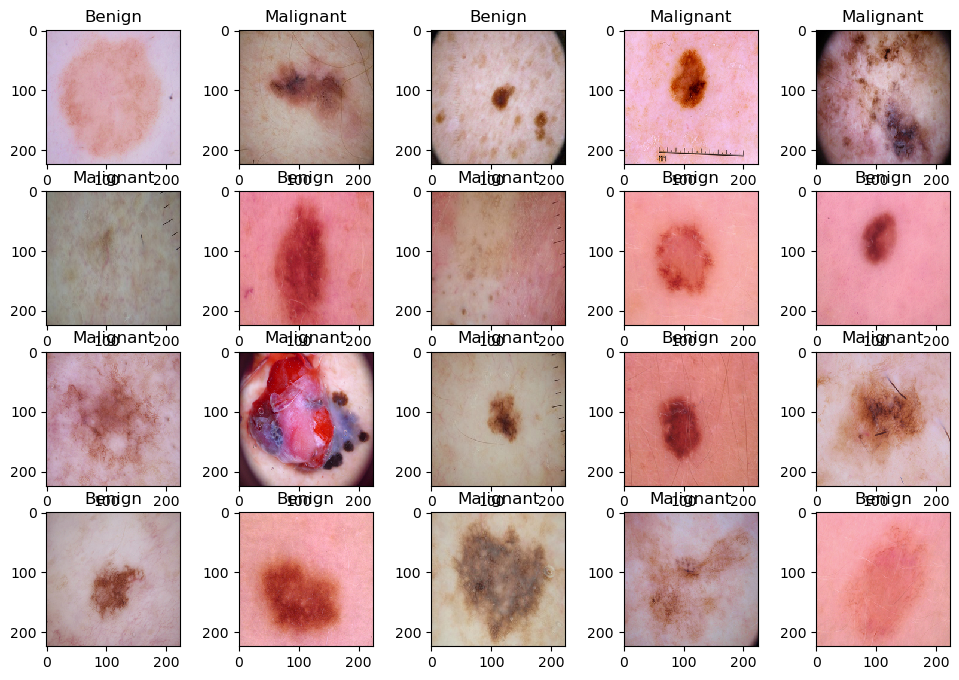

In [23]:
# Display first 20 images of moles along with their classifications
width = 40
height = 40

fig = plt.figure(figsize=(12, 8))
columns = 5
rows = 4

for i in range(1, columns * rows + 1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text("Benign")
    else:
        ax.title.set_text("Malignant")
    plt.imshow(X_train[i], interpolation='nearest')

plt.show()


In [24]:
# Categorical Labels
# Turn labels into One Hot Encoding

y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [25]:
# Normalization
# Normalize all values of the pictures by dividing all the RGB values by 255

X_train = X_train / 255
X_test = X_test / 255

## Build The Model 

In [26]:
def buildModel(input_shape, lr, num_classes, activation, optimizer_type):
    """
    This function builds a Convolutional Neural Network (CNN) model for skin cancer detection.

    Parameters:
    - input_shape (tuple): The shape of the input images (height, width, channels).
    - lr (float): The learning rate for the optimizer.
    - num_classes (int): The number of classes for classification.
    - activation (str): The activation function to be used in the layers.
    - optimizer_type (str): The type of optimizer to be used ('adam' or 'rmsprop').

    Returns:
    - model (keras.models.Sequential): The compiled CNN model.
    """

    model = Sequential()

    # First Convolutional Layer
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', input_shape=input_shape,
                     activation = activation, kernel_initializer='he_uniform'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Second Convolutional Layer
    model.add(Conv2D(128,  kernel_size=(3, 3), padding='same', input_shape=input_shape,
                     activation = activation, kernel_initializer='he_uniform'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Third Convolutional Layer
    model.add(Conv2D(256, kernel_size=(3, 3), padding='same', input_shape=input_shape,
                     activation = activation, kernel_initializer='he_uniform'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Fully connected layer
    model.add(Flatten())
    model.add(Dense(512, activation=activation, kernel_initializer='he_uniform'))
    model.add(Dropout(0.25))
    model.add(Dense(num_classes, activation='softmax'))

    # Optimizer
    if optimizer_type == 'rmsprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = Adam(learning_rate=lr)

    # Ensure num_classes is an integer
    assert isinstance(num_classes, int), "num_classes must be an integer"

    model.compile(optimizer = optimizer, 
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    
    return model


In [27]:
# Set Learning Rate annealer

learning_rate_ = ReduceLROnPlateau(
    monitor = 'val_acc',
    patience = 5,
    verbose = 1,
    factor = 0.5,
    min_lr = 1e-7
)


In [28]:
input_shape = (224, 224, 3)
# num_classes = 2,
lr = 1e-2
activation = 'relu'
optimizer = 'adam'
epochs = 10
batch_size = 32


model = buildModel(
    input_shape= input_shape,
    lr=lr,
    num_classes = 2,
    activation=activation,
    optimizer_type=optimizer
)

In [29]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │   102,760,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,132,802 (393.42 MB)

 Trainable params: 103,132,802 (393.42 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
history = model.fit(
                    X_train, y_train,
                    validation_split = 0.2,
                    epochs = epochs,
                    batch_size = batch_size,
                    verbose=1,
                    callbacks=[learning_rate_]
                )

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.4923 - loss: 9316.4727 - val_accuracy: 0.4900 - val_loss: 0.6972 - learning_rate: 0.0100
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.5160 - loss: 0.6934 - val_accuracy: 0.4900 - val_loss: 0.6945 - learning_rate: 0.0100
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.4961 - loss: 0.6954 - val_accuracy: 0.4900 - val_loss: 0.6933 - learning_rate: 0.0100
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.4586 - loss: 0.6936 - val_accuracy: 0.4900 - val_loss: 0.6932 - learning_rate: 0.0100
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.4963 - loss: 0.6934 - val_accuracy: 0.5100 - val_loss: 0.6931 - learning_rate: 0.0100
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.5243 - loss: 0.6931 - val_accuracy: 0.4900 - val_loss: 0.6936 - learning_rate: 0.0100
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - accuracy: 0.4775 - loss: 0.6940 - val_accurac

In [31]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


## Plotting the accuracy scores

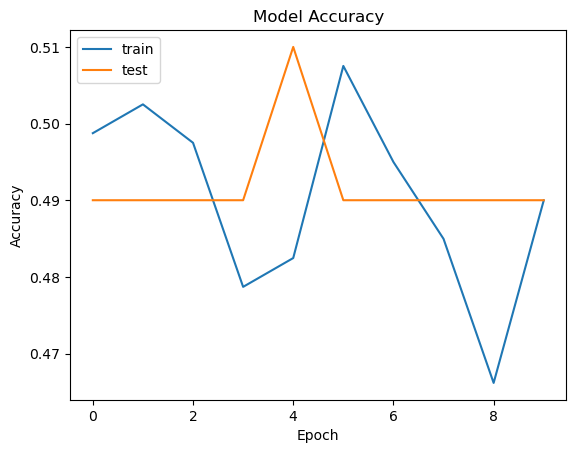

In [32]:
# Summarize the history for accuracy 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')

plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['train', 'test'], loc='upper left')

plt.show()

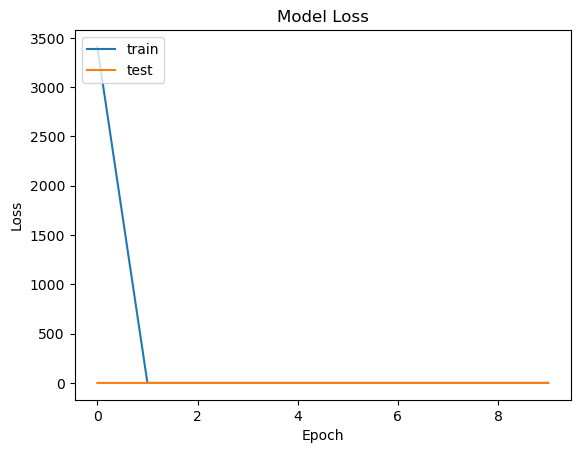

In [33]:
# Summarize the history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')

plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['train', 'test'], loc='upper left')

plt.show()

## Cross Validating the model with k-fold validation

In [34]:
kfold = KFold(n_splits=3, shuffle=True, random_state=11)

cv_scores = []

for train, test in kfold.split(X_train, y_train):

    # create model
    model = buildModel(
        input_shape=input_shape,
        lr=lr,
        num_classes = 2,
        activation=activation,
        optimizer_type=optimizer
    )

    # Fit the model
    model.fit(X_train[train], y_train[train], 
              epochs=epochs, batch_size=batch_size, verbose=0)
    
    # model summary statistics
    model.summary()

    # evaluate the model
    scores = model.evaluate(X_train[train], y_train[train], verbose=0)
    # print(f"Fold {k+1}, Train Score: {scores[1]*100:.2f}%")
    print("\n %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cv_scores.append(scores[1] * 100)
    K.clear_session()
    del model

print("%.2f%% (+/- %.2f%%)" % (np.mean(cv_scores), np.std(cv_scores)))

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │   102,760,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 309,398,408 (1.15 GB)

 Trainable params: 103,132,802 (393.42 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 206,265,606 (786.84 MB)


 compile_metrics: 79.40%



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │   102,760,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 309,398,408 (1.15 GB)

 Trainable params: 103,132,802 (393.42 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 206,265,606 (786.84 MB)


 compile_metrics: 50.23%


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │   102,760,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 309,398,408 (1.15 GB)

 Trainable params: 103,132,802 (393.42 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 206,265,606 (786.84 MB)


 compile_metrics: 72.82%
67.48% (+/- 12.49%)


## Testing the Model

In [36]:
model = buildModel(
    input_shape=input_shape,
    lr=lr,
    num_classes = 2,
    activation=activation,
    optimizer_type=optimizer
)

model.fit(X_train, y_train,
          epochs=epochs, 
          batch_size=batch_size, 
          verbose=1,
          callbacks=[learning_rate_]
        )

model.summary()

y_pred = model.predict(X_test)

# Accuracy Score
accuracy = accuracy_score(np.argmax(y_test, axis=1), 
                          np.argmax(y_pred, axis=1))
print("Accuracy: ", accuracy)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.4996 - loss: 3898.3696 - learning_rate: 0.0100
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.4836 - loss: 0.6946 - learning_rate: 0.0100
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.4807 - loss: 0.6934 - learning_rate: 0.0100
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.5113 - loss: 0.6933 - learning_rate: 0.0100
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.4982 - loss: 0.6934 - learning_rate: 0.0100
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.5160 - loss: 0.6929 - learning_rate: 0.0100
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.5113 - loss: 0.6932 - learning_rate: 0.0100
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.5174 - loss: 0.6928 - learning_rate: 0.0100
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.5076 - loss: 0.6938 - learning_rate: 0.0100
Epoch 10/10
32/32 ━━━━━━━

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │   102,760,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 309,398,408 (1.15 GB)

 Trainable params: 103,132,802 (393.42 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 206,265,606 (786.84 MB)

21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 369ms/step
Accuracy:  0.5455927051671733
